调整分类问题中使用的阈值（即，调整用于决定预测一个类还是另一个类的概率的临界值）是一个有时会被遗忘的步骤，但很容易做到，并且可以显著提高模型的质量。对于大多数分类问题，都应该执行此步骤（有一些例外，具体取决于我们希望优化的目标，如下所述）。

在本文中，我们将仔细研究执行此操作时实际发生的情况 — 特别是对于多类分类，这可能有点微妙。我们看一下我自己编写的一个名为 ClassificationThesholdTuner 的开源工具，它可以自动化并向用户描述该过程。

考虑到调整阈值的任务与分类问题是多么普遍，以及从一个项目到另一个项目的过程通常是多么相似，我已经能够在许多项目中使用此工具。它消除了我为大多数分类问题添加的大量（几乎重复的）代码，并提供了有关调整阈值的更多信息，否则我将拥有这些信息。

尽管 ClassificationThesholdTuner 是一个有用的工具，但您可能会发现本文中描述的工具背后的想法更相关 — 它们很容易在对您的分类项目有用的地方进行复制。

简而言之，ClassificationThesholdTuner 是一种工具，可以最佳地设置用于分类问题的阈值，并清楚地呈现不同阈值的效果。与大多数其他可用选项（以及我们很可能自己开发的用于优化阈值的代码）相比，它有两个主要优势：

它提供可视化效果，帮助数据科学家了解使用发现的最佳阈值的含义，以及可以选择的替代阈值。在向其他利益相关者提交建模决策时，这也非常有价值，例如，当需要在假阳性和假阴性之间找到良好的平衡时。通常，业务理解以及数据建模知识对此是必需的，并且对阈值的选择有清晰和全面的了解可以促进讨论和决定最佳平衡。
它支持多类分类，这是机器学习中的一种常见问题类型，但在优化阈值方面比二元分类更复杂（例如，它需要识别多个阈值）。遗憾的是，其他此类工具并未很好地支持优化用于多类分类的阈值。
尽管支持多类分类是 ClassificationThesholdTuner 的重要属性之一，但二进制分类更容易理解，因此我们首先要介绍这一点。

分类中使用的阈值是什么？
几乎所有现代分类器（包括 scikit-learn、CatBoost、LGBM、XGBoost 和大多数其他分类器中的分类器）都支持生成预测和概率。

例如，如果我们创建一个二元分类器来预测明年哪些客户将流失，那么对于每个客户，我们通常可以生成一个二元预测（每个客户都是 Yes 或 No），或者可以为每个客户生成一个概率（例如，一个客户在该时间范围内离开的概率可能估计为 0.862）。

给定一个可以产生概率的分类器，即使我们要求二进制预测，它也通常会在幕后为每条记录实际生成一个概率。然后，它会将概率转换为类别预测。

默认情况下，二元分类器将预测正类的预测概率大于或等于 0.5 的正类，以及概率低于 0.5 的负类。在此示例中（预测流失），默认情况下，如果预测的流失概率≥ 0.5，则预测为 Yes，否则为 No。

但是，这可能不是理想的行为，通常 0.5 以外的阈值可能更有效，阈值可能略低或略高，有时阈值与 0.5 大不相同。这可能取决于数据、构建的分类器以及误报与漏报的相对重要性。

为了创建一个强大的模型（包括很好地平衡假阳性和假阴性），我们通常希望优化某些指标，例如 F1 分数、F2 分数（或 f-beta 指标系列中的其他指标）、马修斯相关系数 （MCC）、Kappa 分数或其他指标。如果是这样，针对这些指标进行优化的主要部分是适当设置阈值，这通常会将其设置为非 0.5 的值。我们很快就会介绍它是如何工作的。

这是一个关键点。通常不会立即清楚在何处最好地设置阈值，但我们通常可以确定要优化的最佳指标。一个例子是使用 F2 或 F3 分数，我们希望更加强调正类的召回率。

在 Scikit-learn 中支持阈值调整
Scikit-learn 在其 Tuning the decision threshold for class prediction 页面中提供了有关阈值优化思想的良好背景。Scikit-learn 还提供了两个工具：FixedThresholdClassifier 和 TunedThresholdClassifierCV（在 scikit-learn 的 1.5 版本中引入）来帮助调整阈值。它们的工作方式与 ClassificationThesholdTuner 非常相似。

Scikit-learn 的工具可以被认为是便捷的方法，因为它们不是绝对必要的;如前所述，在任何情况下，调优都相当简单（至少对于二进制分类情况，这是这些工具所支持的）。但是，拥有它们很方便 — 调用这些仍然比自己编写流程要容易得多。

ClassificationThresholdTuner 是作为这些工具的替代方案而创建的，但在 scikit-learn 的工具运行良好的情况下，它们也是非常好的选择。具体来说，当你有一个二元分类问题，并且不需要对发现的阈值进行任何解释或描述时，scikit-learn 的工具可以完美地工作，甚至可能稍微方便一些，因为它们允许我们跳过安装 ClassificationThresholdTuner 的一小步。

当需要对找到的阈值进行解释（包括与阈值的替代值相关的一些上下文）时，或者当您遇到多类分类问题时，ClassificationThresholdTuner 可能更有价值。

如前所述，有时本文中描述的想法可能是最有价值的，而不是特定的工具，您可能最好开发自己的代码 — 也许按照类似的思路，但可能在执行时间方面进行了优化，以更有效地处理您拥有的数据。 可能更能够支持其他指标进行优化，或者可能提供阈值调整过程的其他绘图和描述，以提供与您的项目相关的信息。

对于每对概率，我们可以将第一对概率视为负类的概率，将第二对概率视为正类的概率。

但是，对于二元分类，一个概率只是 1.0 减去另一个，因此只有一个类的概率是绝对必要的。事实上，在二元分类问题中使用类概率时，我们通常只使用正类的概率，因此可以使用如下数组：[0.4， 0.7， 0.9， ...]。

在二元情况下，阈值很容易理解，因为它们可以简单地视为正类实际预测正类所需的最小预测概率（在客户流失示例中，用于预测客户流失）。如果我们有一个阈值，比如 0.6，那么很容易将上面的概率数组转换为预测，在本例中为：[No， Yes， Yes， ...]。

通过使用不同的阈值，我们允许模型或多或少地渴望预测正类。如果使用相对较低的阈值（例如 0.3），则模型将预测正类，即使正确的可能性很小。与使用 0.5 作为阈值相比，将对正类进行更多预测，从而增加真阳性和假阳性，同时减少真阴性和假阴性。

在流失的情况下，如果我们想专注于捕获大多数流失情况，这可能很有用，即使这样做，我们也预测许多客户会流失，而他们不会流失。也就是说，当假阴性 （缺失流失率） 比假阳性 （错误预测流失率） 更成问题时，低阈值是好的。

将阈值设置得更高（比如 0.8）会产生相反的效果：预计会流失的客户端会减少，但在预测会流失的客户端中，很大一部分很可能实际上会流失。我们将增加假阴性（错过一些实际会流失的人），但减少假阳性。当我们只能跟进少数可能流失的客户，并且只想标记最有可能流失的客户时，这可能很合适。

在决定在哪里设置阈值时，几乎总是有一个强大的业务因素。ClassificationThresholdTuner 等工具可以使这些决策更加清晰，因为否则阈值通常不会有明显的点。例如，仅根据直觉选择一个阈值（可能确定 0.7 感觉大致正确）不太可能达到最佳效果，通常不会比简单地使用默认值 0.5 更好。

设置阈值可能有点不直观：稍微调高或调低它通常对模型的帮助或伤害比预期的要大。例如，通常，增加阈值可以大大减少假阳性，而对假阴性的影响很小;在其他情况下，情况可能恰恰相反。使用接收者操作员曲线 （ROC） 是帮助可视化这些权衡的好方法。我们将在下面看到一些示例。

最后，我们将设置阈值，以便针对某些指标（例如 F1 分数）进行优化。ClassificationThresholdTuner 只是一个用于自动化和描述该过程的工具。

AUROC 和 F1 分数
一般来说，我们可以将用于分类的指标视为三种主要类型：

那些检查预测概率排名如何的指标，例如：接受者操作员曲线下面积 （AUROC）、精确召回曲线下面积 （AUPRC）
检查预测概率校准程度的那些是：Brier Score、Log Loss
查看预测标签正确程度的指标，例如：F1 分数、F2 分数、MCC、Kappa 分数、平衡准确性
此处列出的前两类指标基于预测概率工作，最后一类指标使用预测标签。

虽然每个类别中都有许多指标，但为简单起见，我们暂时只考虑其中两个更常见的指标，即接收者操作员曲线下面积 （AUROC） 和 F1 分数。

这两个指标有一个有趣的关系（就像 AUROC 与基于预测标签的其他指标一样），ClassificationThresholdTuner 利用它来优化和解释最佳阈值。

ClassificationThresholdTuner 背后的想法是，一旦模型经过良好调整以具有强大的 AUROC，就可以利用它来优化其他指标，即基于预测标签的指标，例如 F1 分数。

基于预测标签的指标
通常，查看预测标签正确程度的指标与分类最相关。在这种情况下，模型将用于将预测标签分配给记录，并且相关的是真阳性、真阴性、假阳性和假阴性的数量。也就是说，如果下游使用的是预测标签，那么一旦分配了标签，基础预测概率就不再相关，只是这些最终标签预测。

例如，如果模型将 Yes （是） 和 No （否） 标签分配给客户，以指示他们是否预计在明年流失，并且预测为 Yes （是） 的客户会接受一些处理，而预测为 No （否） 的客户则不会，则最相关的是这些标签的正确性，而不是最终。 预测概率（这些类谓词所基于的）的排名或校准程度如何。不过，正如我们将看到的，预测概率的排名如何与准确分配预测标签有关。

并非每个项目都是如此：通常，AUROC 或 AUPRC 等指标最相关，这些指标着眼于预测概率的排名程度;通常，诸如 Brier Score 和 Log Loss 之类的指标最相关，这些指标着眼于预测概率的准确程度。

优化阈值不会影响这些指标，并且在这些指标最相关的情况下，没有理由优化阈值。但是，在本文中，我们将考虑 F1 分数或基于预测标签的其他指标是我们希望优化的情况。

ClassificationThresholdTuner 从预测概率开始（其质量可以使用 AUROC 进行评估），然后优化指定的指标（其中指定的指标基于预测的标签）。

基于预测标签正确性的指标都以不同的方式从混淆矩阵计算得出。反过来，混淆矩阵基于所选的阈值，并且根据使用的是低阈值还是高阈值，看起来可能会大不相同。

调整阈值
AUROC 指标，顾名思义，基于 ROC，是一条显示真阳性率与假阳性率的关系的曲线。ROC 曲线不假定使用任何特定阈值。但是，曲线上的每个点都对应于一个特定的阈值。

在下图中，蓝色曲线是 ROC。该曲线下的面积 （AUROC） 衡量模型在所有潜在阈值上的平均值通常的强度。它衡量概率的排名程度：如果概率排名良好，则分配了较高预测概率的记录实际上更有可能处于正类别中。

首先，拥有具有强大 AUROC 的模型很重要——这是模型调优过程的工作（实际上可能会针对其他指标进行优化）。这是在我们开始调整阈值之前完成的，因此，拥有排名良好的概率非常重要，这意味着 AUROC 分数很高。

然后，如果项目需要对所有记录进行类预测，则需要选择一个阈值（尽管可以使用默认值 0.5，但结果可能不是最优的），这相当于在 ROC 曲线上选择一个点。

上图显示了 ROC 上的两个点。对于每个轴，在x轴和y轴上绘制一条垂直线和一条水平线，以指示相关的真阳性率和假阳性率。

给定 ROC 曲线，当我们向左和向下移动时，我们将使用更高的阈值（例如，从绿线到红线）。预测为正值的记录较少，因此真阳性和假阳性都会减少。

当我们向右和向上移动时（例如，从红线到绿线），我们将使用较低的阈值。预测为正值的记录越多，因此会有更多的真阳性和更多的假阳性。

也就是说，在此处的图中，红线和绿线表示两个可能的阈值。从绿线到红线，我们看到真阳性率略有下降，但假阳性率下降幅度更大，因此这很可能是比绿线所在的阈值更好的阈值选择。但不一定 — 我们还需要考虑假阳性和假阴性的相对成本。

但是，重要的是，从一个阈值移动到另一个阈值通常可以比 True Positive Rate 调整假阳性率或多或少得多。

可以查看 ROC 曲线，并查看上下移动阈值的效果。鉴于此，在某种程度上，有可能仔细观察该过程，并选择一个似乎最能平衡真阳性和假阳性的点（这也有效地平衡了假阳性和假阴性）。从某种意义上说，这就是 ClassificationThesholdTuner 所做的，但它以一种有原则的方式这样做，以便针对特定的指定指标（例如 F1 分数）进行优化。

将阈值移动到 ROC 上的不同点会生成不同的混淆矩阵，然后可以将其转换为指标（F1 分数、F2 分数、MCC 等）。然后，我们可以选择优化此分数的点。

如果排名良好，模型不一定也经过良好校准，但这不是必需的：只要正类中的记录往往比负类中的记录获得更高的预测概率，我们就可以找到一个好的阈值，将预测为正的记录与预测为负的记录区分开来。

从另一个角度来看，我们可以用两个直方图来查看二元分类问题中的概率分布，如下所示（实际上使用 KDE 图）。蓝色曲线显示负类的概率分布，橙色曲线显示正类的概率分布。该模型可能没有经过很好的校准：正类的概率始终远低于 1.0。但是，它们的排名很好：正类的概率往往高于负类的概率，这意味着模型将具有较高的 AUROC，并且如果使用适当的阈值，模型可以很好地分配标签，在这种情况下，可能约为 0.25 或 0.3。但是，鉴于分布中存在重叠，不可能有一个完美的系统来标记记录，并且 F1 分数永远不会完全为 1.0。

即使 AUROC 分数很高，也可能具有较低的 F1 分数：阈值选择不佳。例如，当 ROC 紧贴轴时，如上所示的 ROC 所示，可能会发生这种情况 — 非常低或非常高的阈值可能效果不佳。在数据不平衡的地方也可能发生紧贴 y 轴。

在此处显示的直方图中，尽管模型经过良好校准并且具有较高的 AUROC 分数，但阈值选择不当（例如 0.5 或 0.6，这将导致所有内容都被预测为负类）将导致 F1 分数非常低。

也有可能（尽管不太可能）拥有低 AUROC 和高 F1 分数。这可以通过选择特别好的 threshold 来实现 （大多数 thresholds 的性能会很差）。

同样，ROC 曲线不对称并不常见，但可能会有不对称的 ROC 曲线，这会极大地影响阈值的最佳放置位置。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from threshold_tuner import ClassificationThresholdTuner

In [9]:
from sklearn.preprocessing import MinMaxScaler
import sys

In [6]:
NUM_ROWS = 100_000 
def generate_data_1():
    num_rows_per_class = NUM_ROWS // 2
    np.random.seed(0)
    d = pd.DataFrame({"Y": ['A']*num_rows_per_class + ['B']*num_rows_per_class,
                  "Pred_Proba": 
                      np.random.normal(0.5, 0.1, num_rows_per_class).tolist() + \
                      np.random.normal(1.5, 0.1, num_rows_per_class).tolist()
                 })
    return d, ['A', 'B']

# Similar to generate_data_1(), but the predictions overlap more
def generate_data_2():
    num_rows_per_class = NUM_ROWS // 2
    np.random.seed(0)
    d = pd.DataFrame({"Y": ['A']*num_rows_per_class + ['B']*num_rows_per_class,
                  "Pred_Proba": 
                      np.random.normal(0.7, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(1.4, 0.3, num_rows_per_class).tolist()
                 })
    return d, ['A', 'B']

In [7]:
d,target_classes = generate_data_2()
d

,Y,Pred_Proba
0,A,1.229216
1,A,0.820047
2,A,0.993621
3,A,1.372268
4,A,1.260267
...,...,...
99995,B,1.298686
99996,B,0.791435
99997,B,1.617855
99998,B,1.049651


In [8]:
target_classes

['A', 'B']

In [10]:
scaler = MinMaxScaler() 
proba_cols = [x for x in d.columns if "Proba" in x] 
for col_name in proba_cols:
    d[col_name] = scaler.fit_transform(d[col_name].values.reshape(-1,1)).reshape(1, -1)[0]
    d[col_name] = [x if x <= 1.0 else 1.0 for x in d[col_name]]
    d[col_name] = [x if x >= 0.0 else 0.0 for x in d[col_name]]

In [12]:
d['Pred'] = np.where(d["Pred_Proba"] > 0.50,"B","A")
d

,Y,Pred_Proba,Pred
0,A,0.571782,B
1,A,0.450386,A
2,A,0.501884,B
3,A,0.614224,B
4,A,0.580995,B
...,...,...,...
99995,B,0.592393,B
99996,B,0.441897,A
99997,B,0.687088,B
99998,B,0.518507,B


In [13]:
d.dtypes

Y              object
Pred_Proba    float64
Pred           object
dtype: object

d:\xuexi\使用 ClassificationThresholdTuner 获得更好的分类结果\threshold_tuner.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  display_df = pd.concat([display_df, pd.DataFrame([['Precision'] + prec_arr.tolist()], columns=display_df.columns)])


,Metric,A,B,Macro
0,Precision,0.910200,0.846962,0.878581
0,Recall,0.834180,0.917700,0.875940
0,F1,0.870533,0.880913,0.875723


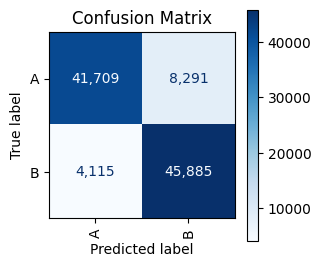

In [14]:
tuner = ClassificationThresholdTuner() 
tuner.print_stats_labels(
    y_true=d["Y"],
    target_classes=target_classes,
    y_pred=d["Pred"]
)

d:\xuexi\使用 ClassificationThresholdTuner 获得更好的分类结果\threshold_tuner.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  display_df = pd.concat([display_df, pd.DataFrame([['Precision'] + prec_arr.tolist()], columns=display_df.columns)])


,Metric,A,B,Macro
0,Precision,0.910200,0.846962,0.878581
0,Recall,0.834180,0.917700,0.875940
0,F1,0.870533,0.880913,0.875723


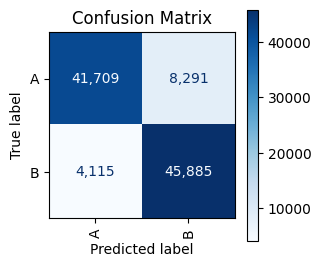

,Metric,Score
0,Brier Score,0.164794
1,AUROC,0.951993


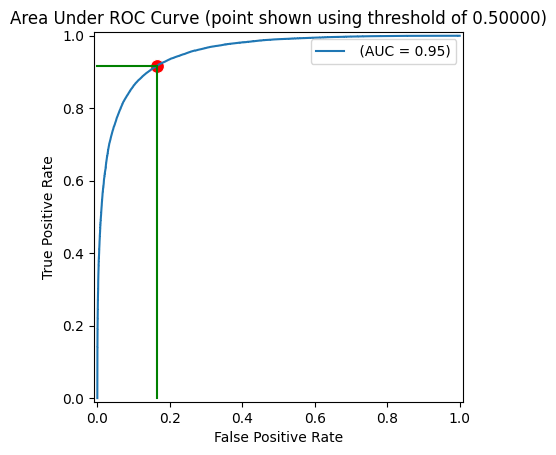

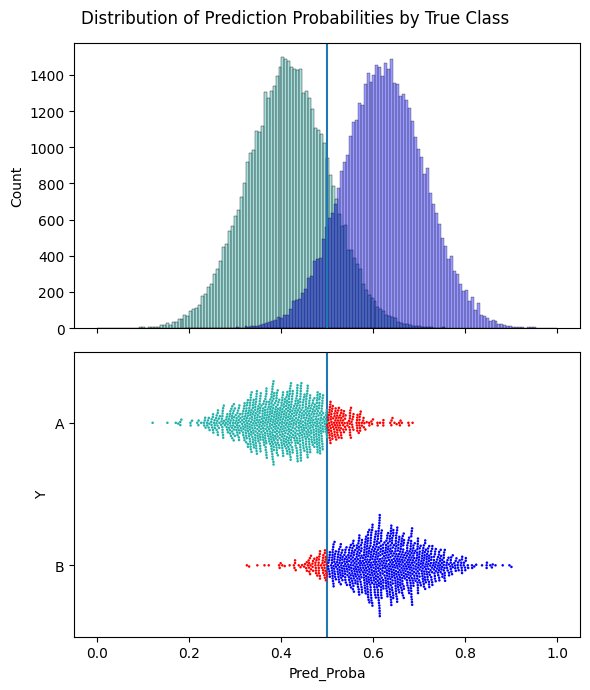

In [15]:
tuner.print_stats_proba(
    y_true=d["Y"],
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"]
)

,Start Range %,End Range %,Min Probability,Max Probability,Count A,Count B,Total Count,Precision,Recall,Cumulative Count B,Cumulative Total Count,Cumulative Precision,Cumulative Recall
0,0.9,1.0,0.697954,0.980241,35,9965,10000,0.996500,0.19930,9965,10000,0.996500,0.19930
1,0.8,0.9,0.646358,0.697952,197,9803,10000,0.980300,0.19606,19768,20000,0.988400,0.39536
2,0.7,0.8,0.604022,0.646353,598,9402,10000,0.940200,0.18804,29170,30000,0.972333,0.58340
3,0.6,0.7,0.562329,0.604015,1529,8471,10000,0.847100,0.16942,37641,40000,0.941025,0.75282
4,0.5,0.6,0.518452,0.562327,3558,6442,10000,0.644200,0.12884,44083,50000,0.881660,0.88166
5,0.4,0.5,0.474919,0.518452,6465,3535,10000,0.353500,0.07070,47618,60000,0.793633,0.95236
6,0.3,0.4,0.433217,0.474907,8452,1547,9999,0.154715,0.03094,49165,69999,0.702367,0.98330
7,0.2,0.3,0.391629,0.433217,9421,580,10001,0.057994,0.01160,49745,80000,0.621812,0.99490
8,0.1,0.2,0.339510,0.391624,9786,214,10000,0.021400,0.00428,49959,90000,0.555100,0.99918
9,0.0,0.1,0.000000,0.339499,9959,40,9999,0.004000,0.00080,49999,99999,0.499995,0.99998


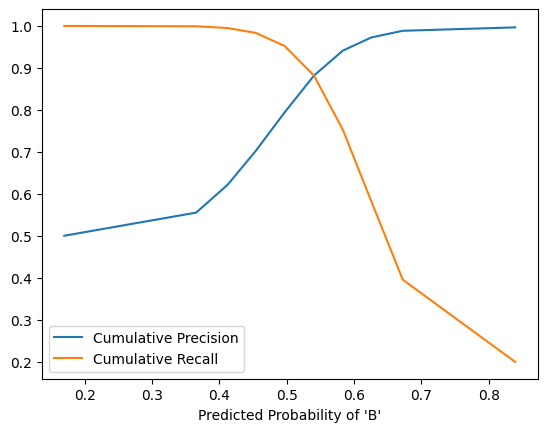

In [16]:
tuner.print_stats_table(
    y_true=d['Y'],
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"],
    num_ranges=10
)

100%|██████████| 9/9 [00:37<00:00,  4.14s/it]


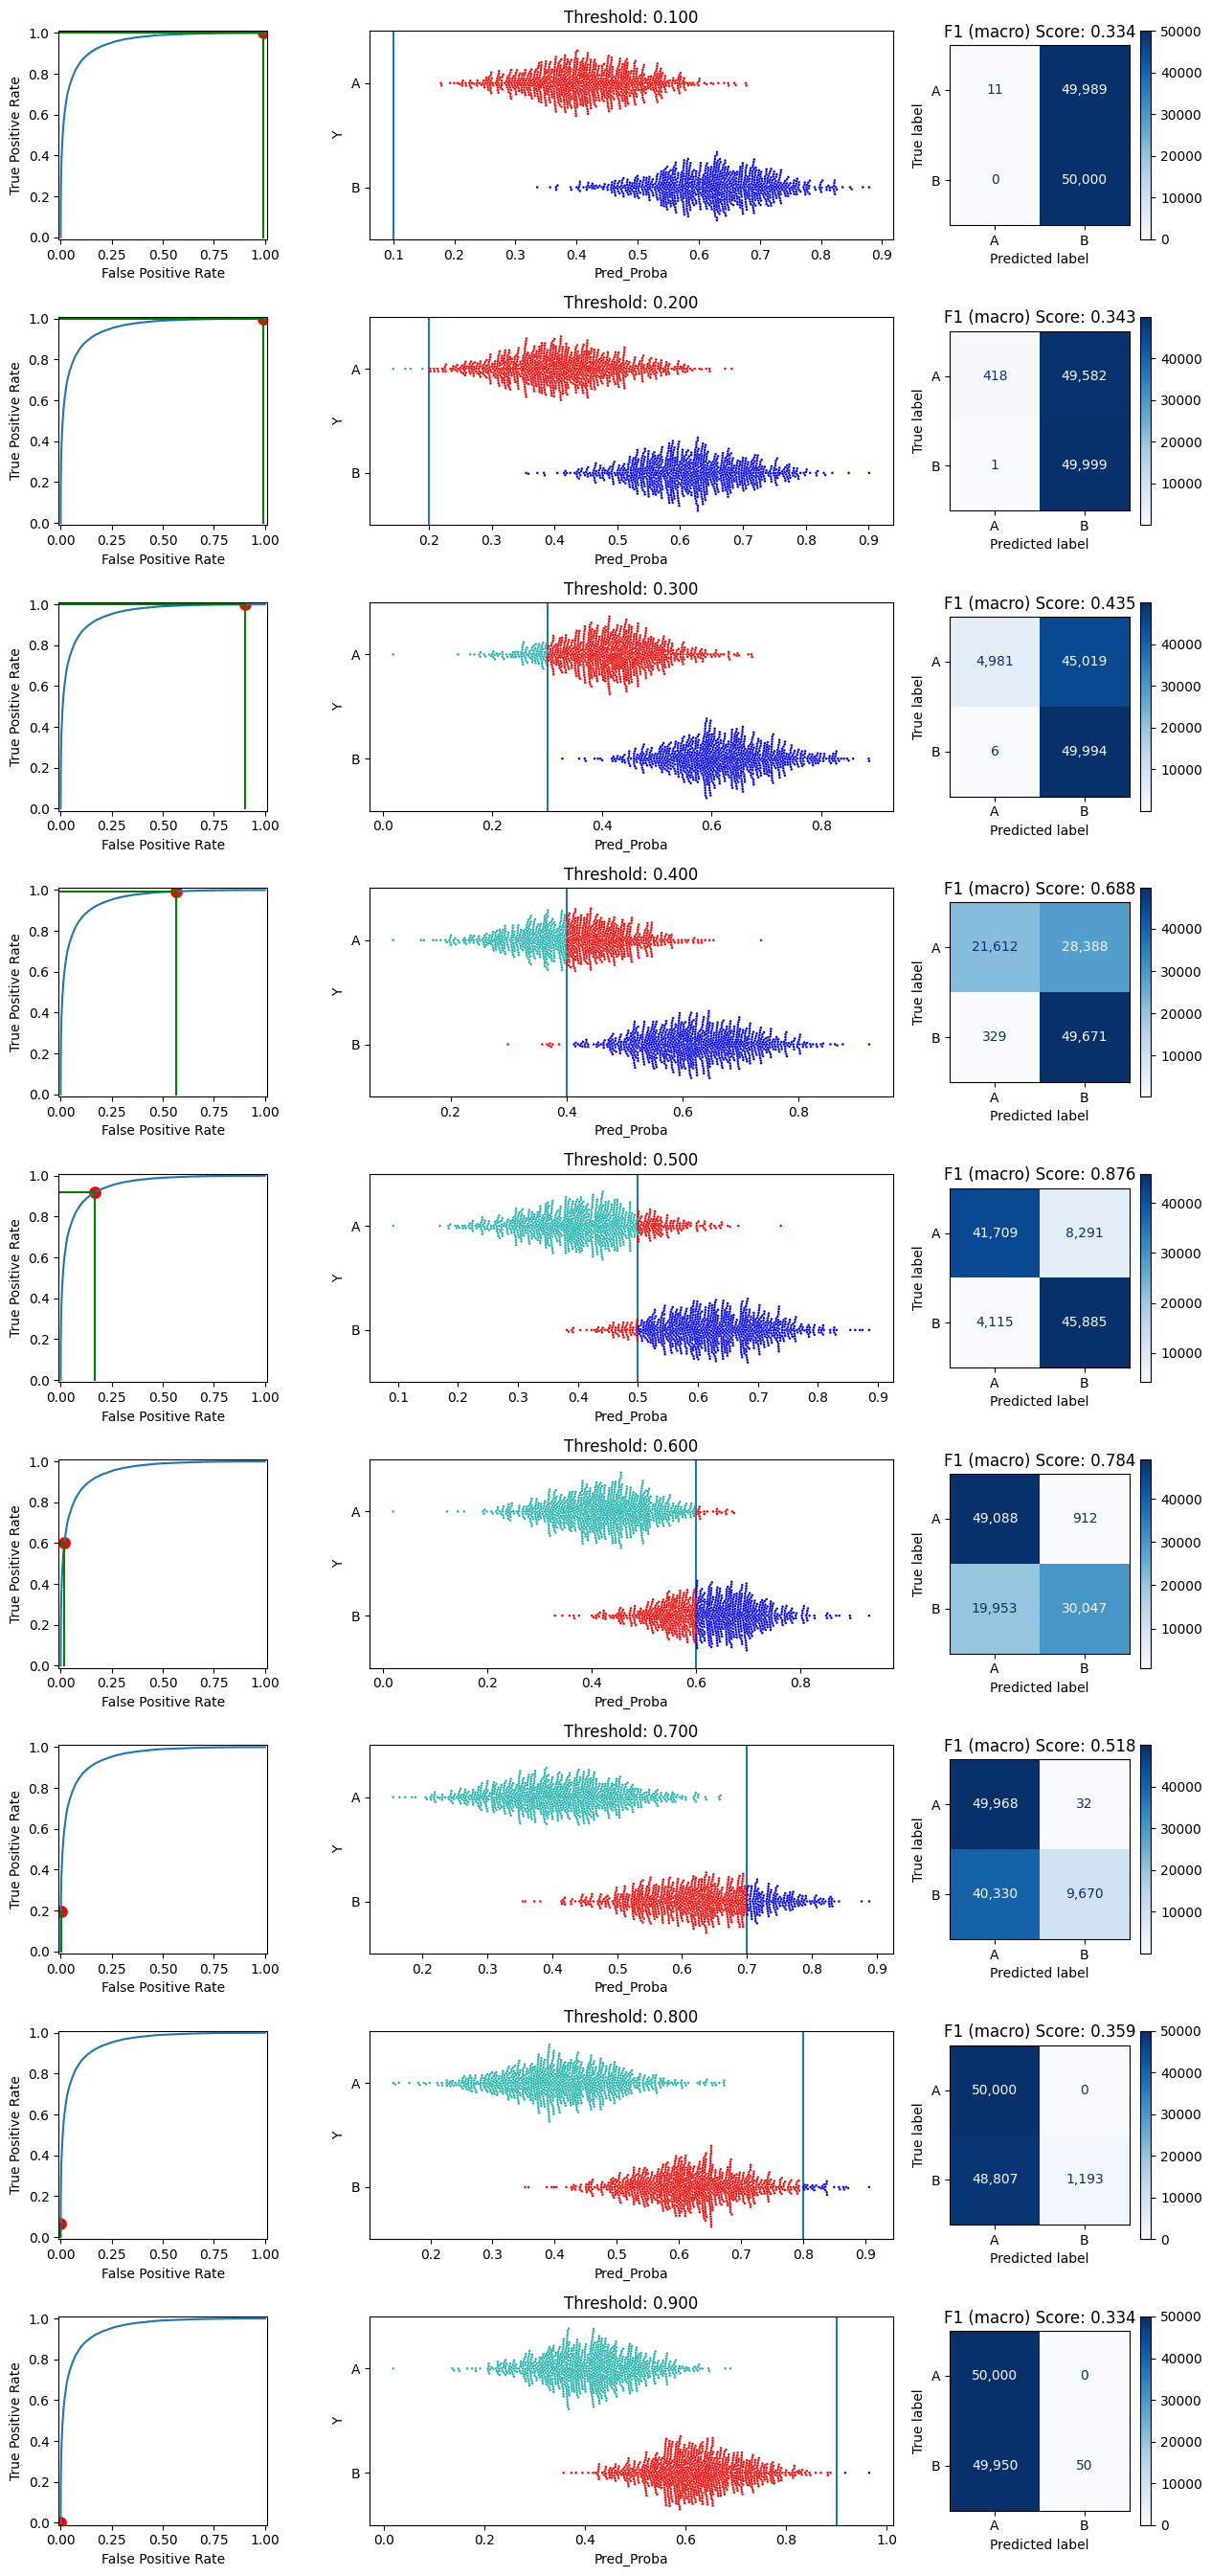

In [17]:
tuner.plot_by_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"])

100%|██████████| 6/6 [00:19<00:00,  3.19s/it]


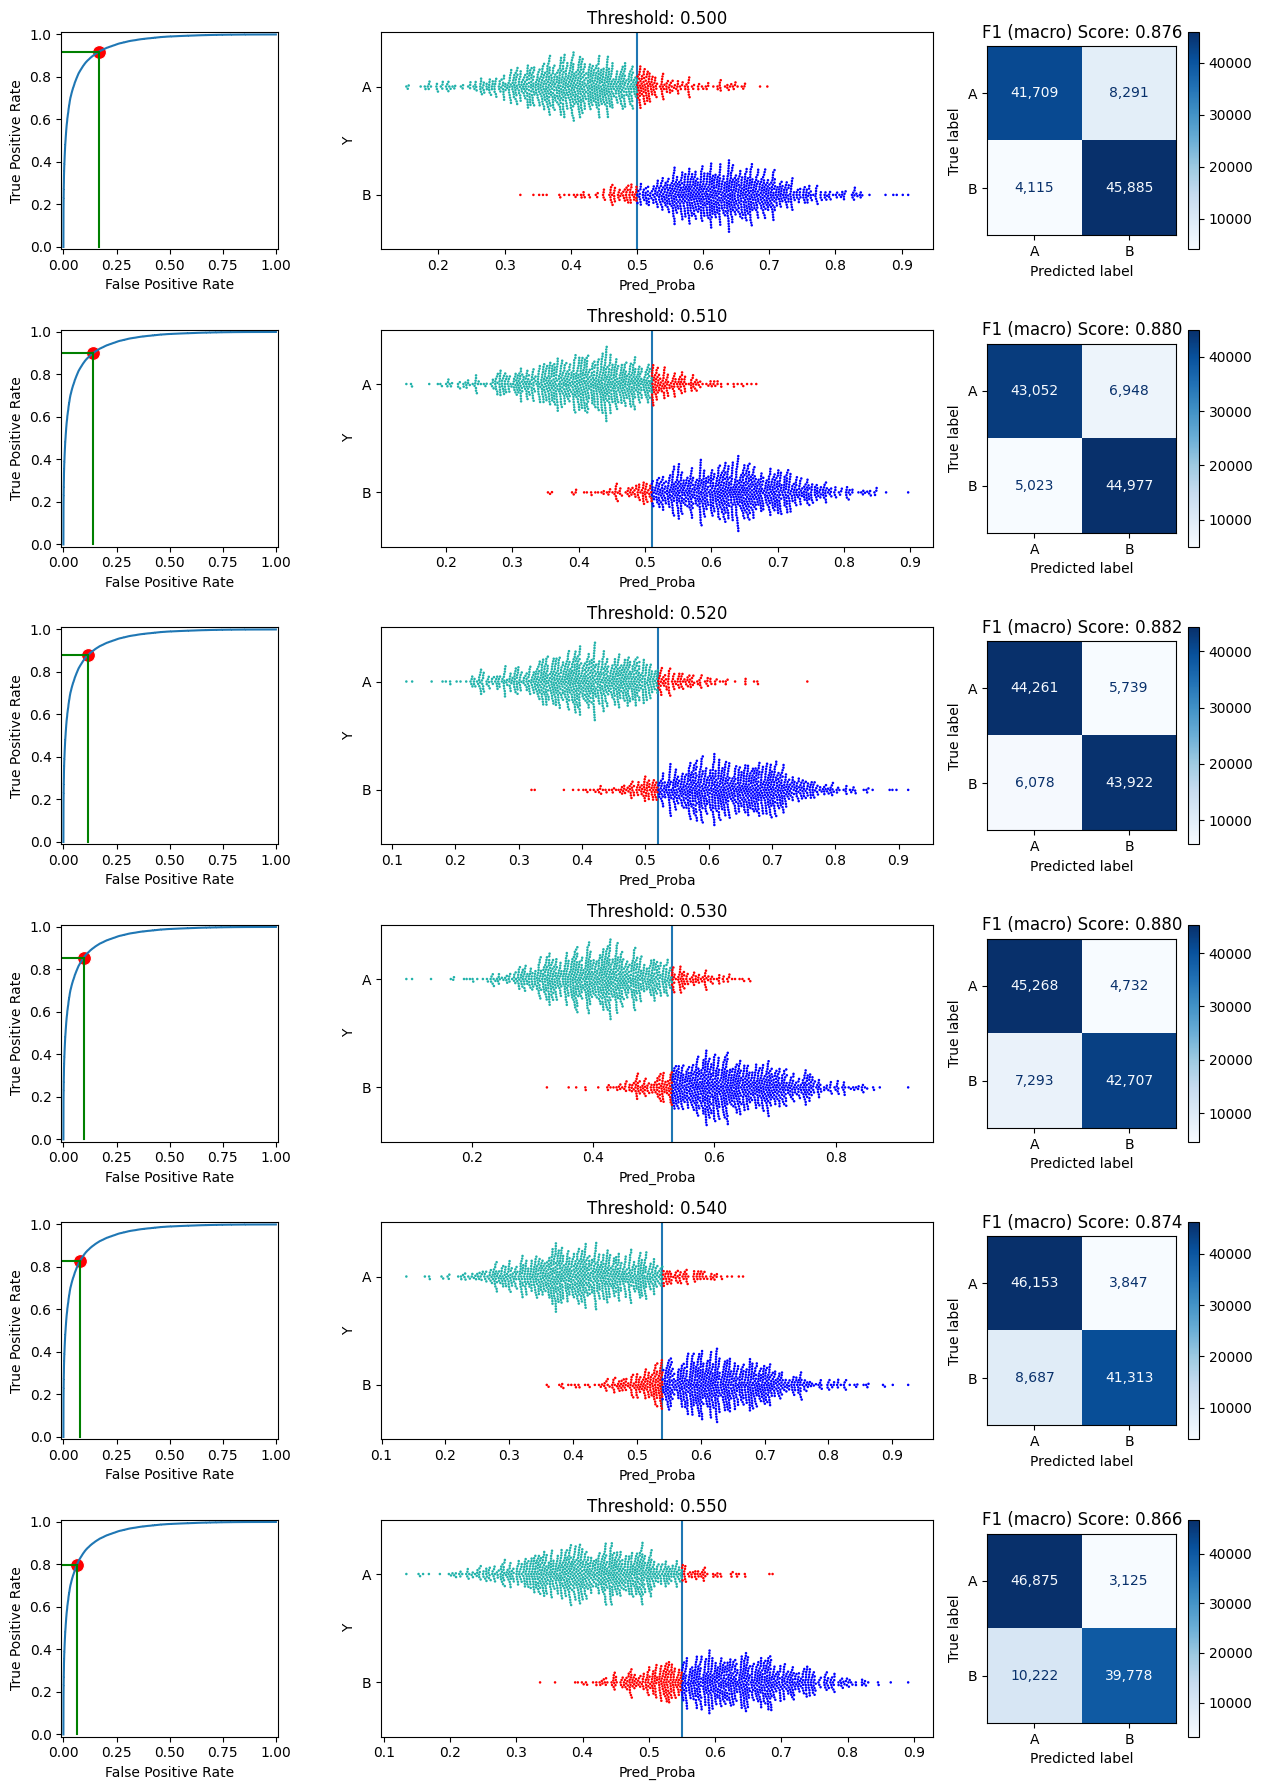

In [18]:
tuner.plot_by_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"], 
    start=0.50, end=0.55, num_steps=6)

d:\xuexi\使用 ClassificationThresholdTuner 获得更好的分类结果\threshold_tuner.py:728: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,
d:\xuexi\使用 ClassificationThresholdTuner 获得更好的分类结果\threshold_tuner.py:745: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,


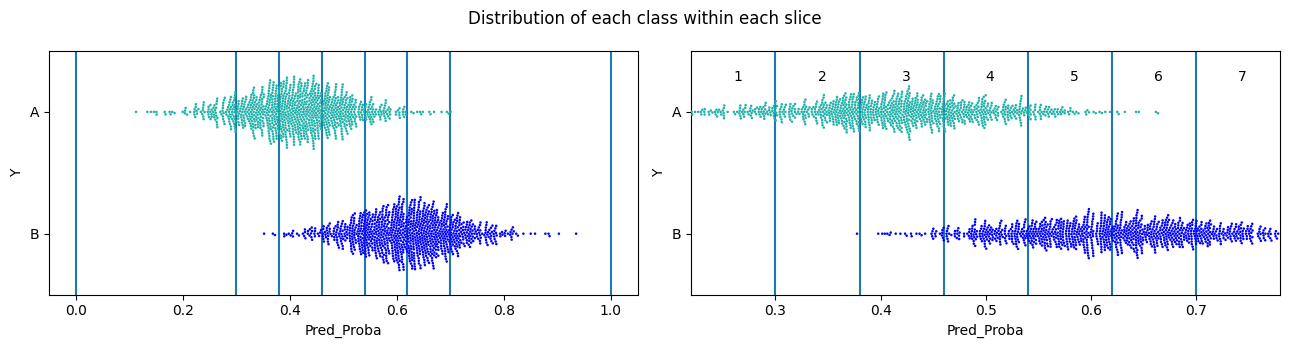

,Slice,Min Prob,Max Prob,A,B,Total,Fraction A,Fraction B
0,1,0.00,0.30,4980,6,4986,0.998797,0.001203
1,2,0.30,0.38,12332,169,12501,0.986481,0.013519
2,3,0.38,0.46,17529,1464,18993,0.922919,0.077081
3,4,0.46,0.54,11311,7048,18359,0.616101,0.383899
4,5,0.54,0.62,3310,15688,18998,0.174229,0.825771
5,6,0.62,0.70,505,15955,16460,0.030680,0.969320
6,7,0.70,1.00,32,9670,9702,0.003298,0.996702


In [19]:
tuner.describe_slices(    
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"], 
    start=0.3, end=0.7, num_slices=5)

d:\xuexi\使用 ClassificationThresholdTuner 获得更好的分类结果\threshold_tuner.py:728: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,
d:\xuexi\使用 ClassificationThresholdTuner 获得更好的分类结果\threshold_tuner.py:745: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,


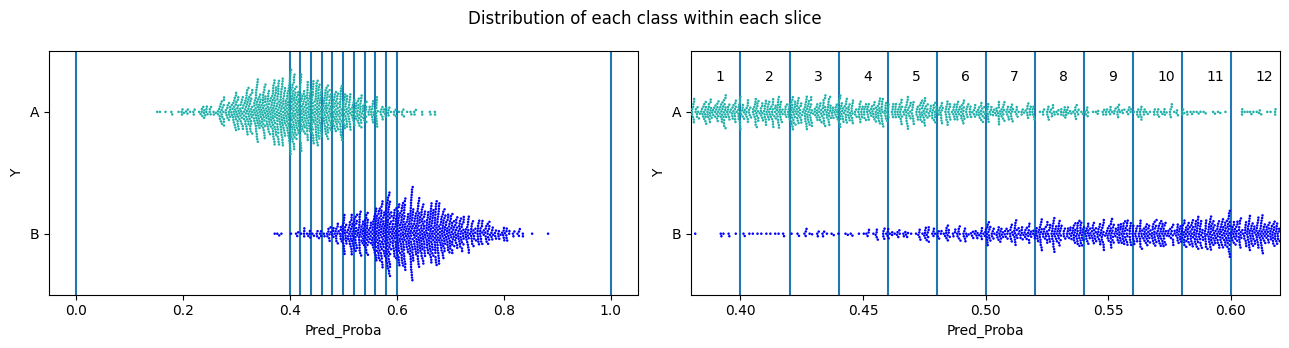

,Slice,Min Prob,Max Prob,A,B,Total,Fraction A,Fraction B
0,1,0.00,0.40,21611,329,21940,0.985005,0.014995
1,2,0.40,0.42,4611,228,4839,0.952883,0.047117
2,3,0.42,0.44,4447,439,4886,0.910151,0.089849
3,4,0.44,0.46,4172,643,4815,0.866459,0.133541
4,5,0.46,0.48,3626,1029,4655,0.778947,0.221053
5,6,0.48,0.50,3241,1447,4688,0.691340,0.308660
6,7,0.50,0.52,2552,1963,4515,0.565227,0.434773
7,8,0.52,0.54,1892,2609,4501,0.420351,0.579649
8,9,0.54,0.56,1351,3248,4599,0.293760,0.706240
9,10,0.56,0.58,992,3753,4745,0.209062,0.790938


In [20]:
tuner.describe_slices(    
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"], 
    start=0.4, end=0.6, num_slices=10)

d:\xuexi\使用 ClassificationThresholdTuner 获得更好的分类结果\threshold_tuner.py:728: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,
d:\xuexi\使用 ClassificationThresholdTuner 获得更好的分类结果\threshold_tuner.py:745: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=d_sample, orient='h', x="Pred_Proba", y="Y", s=swarm_dot_size, order=target_classes,


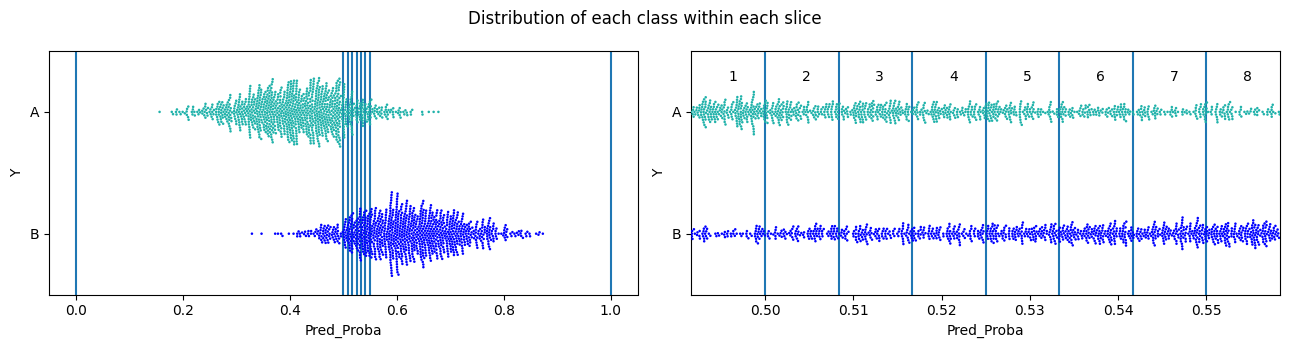

,Slice,Min Prob,Max Prob,A,B,Total,Fraction A,Fraction B
0,1,0.000000,0.500000,41708,4115,45823,0.910198,0.089802
1,2,0.500000,0.508333,1144,763,1907,0.599895,0.400105
2,3,0.508333,0.516667,1028,849,1877,0.547682,0.452318
3,4,0.516667,0.525000,906,919,1825,0.496438,0.503562
4,5,0.525000,0.533333,784,1093,1877,0.417688,0.582312
5,6,0.533333,0.541667,720,1203,1923,0.374415,0.625585
6,7,0.541667,0.550000,584,1280,1864,0.313305,0.686695
7,8,0.550000,1.000000,3125,39778,42903,0.072839,0.927161


In [21]:

# Zoom in further

tuner.describe_slices(    
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"], 
    start=0.5, end=0.55, num_slices=6)

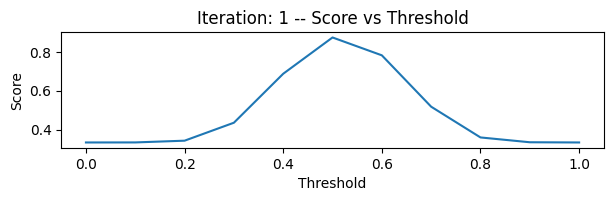

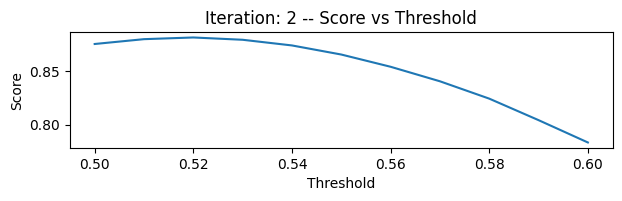

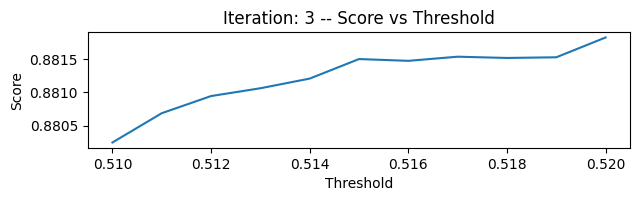

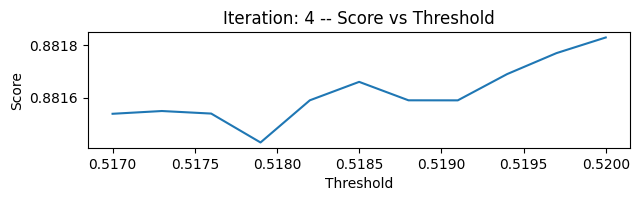

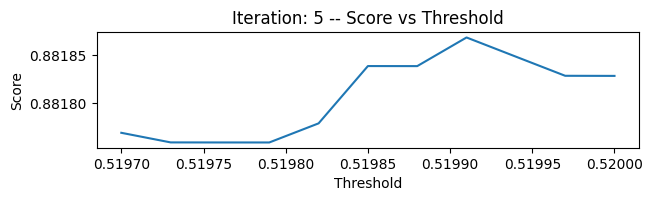

0.5199100000000003

In [22]:
from sklearn.metrics import f1_score

best_threshold = tuner.tune_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"],
    metric=f1_score,
    average='macro',
    higher_is_better=True,
    max_iterations=5
)
best_threshold

In [23]:
tuned_pred = tuner.get_predictions(target_classes, d["Pred_Proba"], None, best_threshold)

# Show the first 10 predictions
tuned_pred[:10]

['B', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'A']

d:\xuexi\使用 ClassificationThresholdTuner 获得更好的分类结果\threshold_tuner.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  display_df = pd.concat([display_df, pd.DataFrame([['Precision'] + prec_arr.tolist()], columns=display_df.columns)])


,Metric,A,B,Macro
0,Precision,0.879464,0.884307,0.881885
0,Recall,0.885040,0.878700,0.881870
0,F1,0.882243,0.881494,0.881869


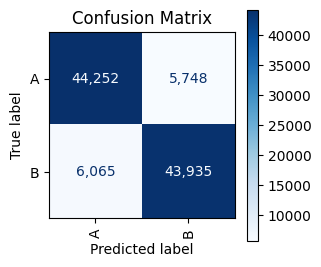

In [24]:
d['Pred'] = np.where(d["Pred_Proba"] > best_threshold, "B", "A")
    
tuner.print_stats_labels(
    y_true=d["Y"], 
    target_classes=target_classes,
    y_pred=d["Pred"])    

d:\xuexi\使用 ClassificationThresholdTuner 获得更好的分类结果\threshold_tuner.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  display_df = pd.concat([display_df, pd.DataFrame([['Precision'] + prec_arr.tolist()], columns=display_df.columns)])


,Metric,A,B,Macro
0,Precision,0.879464,0.884307,0.881885
0,Recall,0.885040,0.878700,0.881870
0,F1,0.882243,0.881494,0.881869


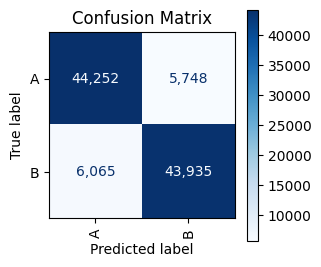

,Metric,Score
0,Brier Score,0.164794
1,AUROC,0.951993


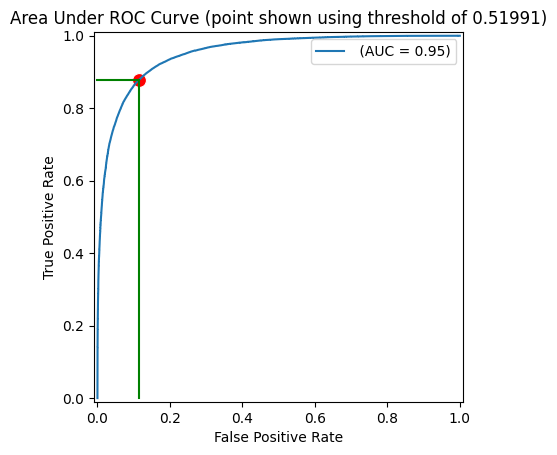

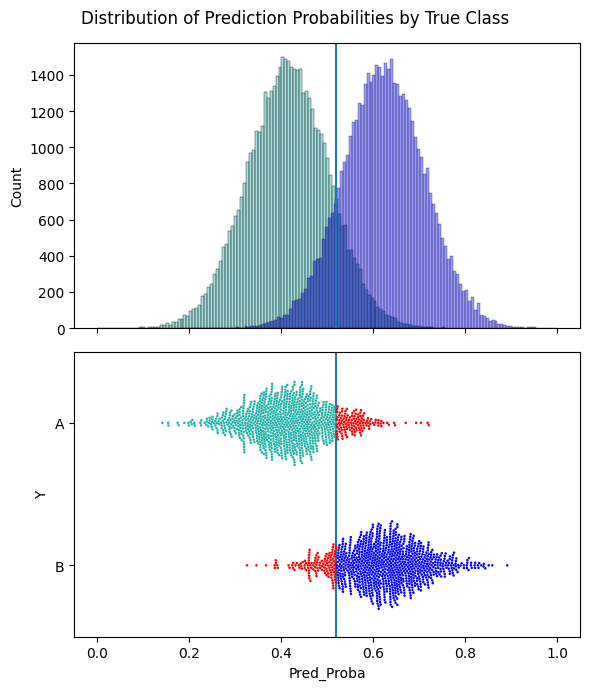

In [25]:
tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d["Pred_Proba"],
    thresholds=best_threshold
)  

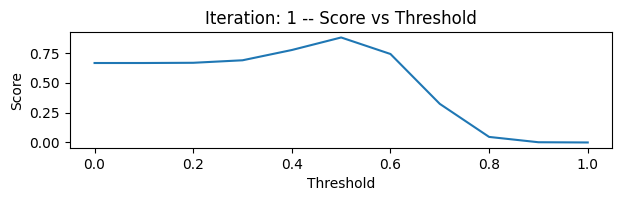

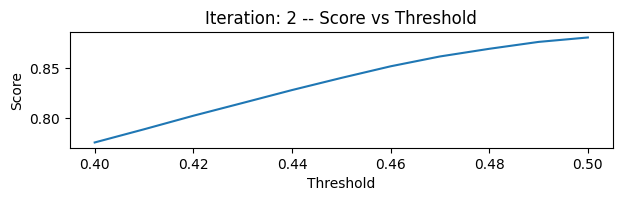

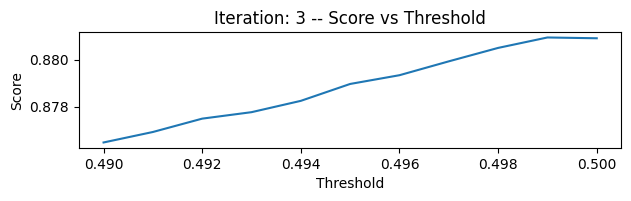

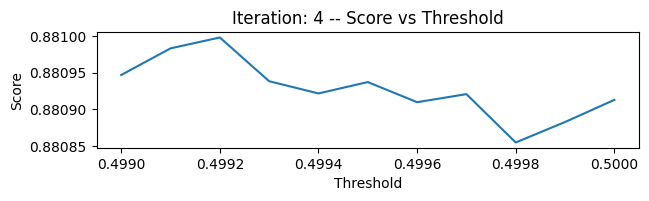

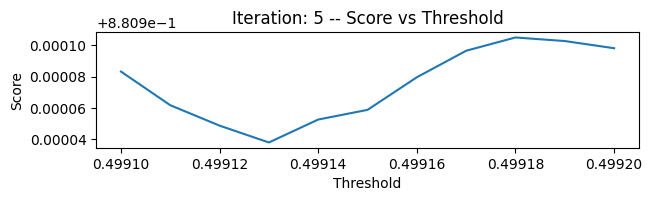

0.4991800000000002

In [26]:
best_threshold = tuner.tune_threshold(
    y_true=d['Y'],
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"],
    metric=f1_score,
    average='binary',
    pos_label='B',
    higher_is_better=True,
    max_iterations=5,
    plot_thresholds=True
)
best_threshold